# Modern Portfolio Theory

In [50]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [51]:
from datetime import datetime
today=datetime.today().strftime('%Y-%m-%d')

In [52]:
from scipy.optimize import minimize
from numba import jit

## Example, 2 companies shares

## Intro

In [53]:
tickers_list = ['JPM','AAPL']
tickers_list=sorted(tickers_list)
tickers_list

['AAPL', 'JPM']

In [54]:
# Get the data for the stock AAPL
data = yf.download(tickers_list,'2018-05-20',today)

[*********************100%***********************]  2 of 2 completed


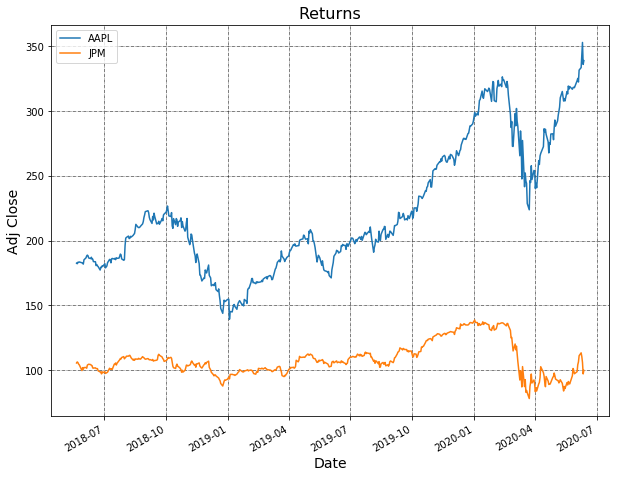

In [55]:
(data['Adj Close']).plot(figsize=(10,8),linestyle='-')
plt.title('Returns', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adj Close',fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.legend()
plt.show()

We only need montly Adj Close.

In [56]:
d=yf.download(tickers_list,'2018-01-01',today,interval='1mo')

[*********************100%***********************]  2 of 2 completed


In [57]:
mdata=d['Adj Close'].dropna()

In [58]:
mreturn=mdata.pct_change()

The next columns are the 'annual increase' in percentages for the different months.

In [59]:
yr_return=mreturn.multiply(365/mdata.index.to_series().diff().dt.days, axis="index")

In [60]:
yr_mean=yr_return.mean()
yr_mean

AAPL    0.356087
JPM    -0.006381
dtype: float64

In [61]:
yr_mean.values

array([ 0.35608708, -0.00638145])

In [62]:
yr_var=yr_return.var()
yr_var

AAPL    1.207628
JPM     0.838152
dtype: float64

Here we clearly see that a high average return gives a high variance (more risk).

### Covariant Matrix

In [63]:
covar=yr_return.cov()
covar

,AAPL,JPM
AAPL,1.207628,0.564815
JPM,0.564815,0.838152


In [64]:
np_covar=covar.values

### Expected return and variance

In [65]:
def exp_return(alpha):
    return alpha @ np.transpose(yr_mean.values)

In [66]:
def variance(alpha):
    term1=0
    term2=0
    for i in range(len(alpha)):        
        for j in range(len(alpha)):
            if i!=j:
                term2+=alpha[i]*alpha[j]*np_covar[i,j]
            else:
                term1+=(alpha[i]**2)*np_covar[i,i]
    return term1+term2

### Plot with different weights

In [67]:
w=np.array([0,0])
for i in range(101):
    x=np.array([i, 100-i])
    w=np.vstack((w,x))


w=w[1:,:]/100

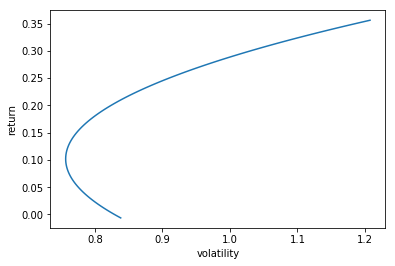

In [68]:
R=[]
V=[]
for i in w:
    R=np.append(R,exp_return(i))
    V=np.append(V,variance(i))
    
plt.plot(V,R)
plt.xlabel('volatility')
plt.ylabel('return')
plt.show()  

All the point on the graphs represent different compositions of the weights which equal to 1. As an investor we don't want to lose money so if we have to invest in these two stocks we chose the most left point on this graph, the point with mimimum variance which translates into risk. If the investor is a bit more 'ballsy' he can pick point on the graph more on the right. Then it becomes obvious that he has to chose a point that is in 'the upper halve' because that gives a higher return for the same amount of risk. Now we create an algorithm that finds the minumum of risk for the 2 stocks.

In [69]:
def constraint(alpha):
    s=sum(alpha)
    return 1-s

cons=[{'type': 'eq','fun': constraint}]

In [70]:
weight0=[1,1]

In [71]:
sol=minimize(variance, weight0, constraints=cons)
sol

     fun: 0.756600825153162
     jac: array([1.51320167, 1.51320166])
 message: 'Optimization terminated successfully.'
    nfev: 16
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.29835385, 0.70164615])

In [72]:
np.size(yr_mean.values)

2

In [73]:
expected_return=(sol.x)@(np.transpose(yr_mean.values))
expected_return

0.10176243094041615

In [74]:
print('Weights distribution with least amount of risk')
print(tickers_list)
print(sol.x)
print('')
print( 'Expected return:' , round(expected_return,3)*100, '%' )
print('Variance:' , round(sol.fun,3), '%')

Weights distribution with least amount of risk
['AAPL', 'JPM']
[0.29835385 0.70164615]

Expected return: 10.2 %
Variance: 0.757 %


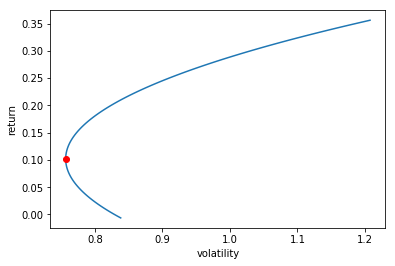

In [75]:
plt.plot(V,R)
plt.plot(sol.fun,expected_return,'ro')
plt.xlabel('volatility')
plt.ylabel('return')
plt.show() 

# Three shares, more in depth guide

Principle is totally the same and now we will focus on just the minimum risk point, that is what we try to achieve and is the whole point of risk minimisation.

In [76]:
tickers_list = ['JPM','AAPL','TSLA']
tickers_list=sorted(tickers_list)
tickers_list

['AAPL', 'JPM', 'TSLA']

In [77]:
n=len(tickers_list)

[*********************100%***********************]  3 of 3 completed


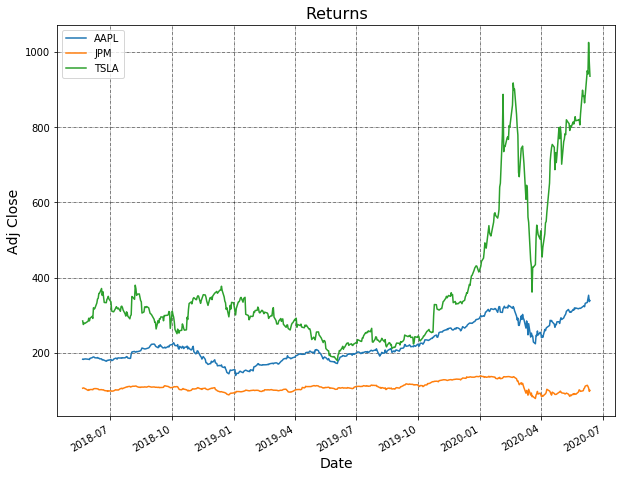

In [78]:
# Get the data for the stock AAPL
data = yf.download(tickers_list,'2018-05-20',today)
(data['Adj Close']).plot(figsize=(10,8),linestyle='-')
plt.title('Returns', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adj Close',fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.legend()
plt.show()

In [79]:
d=yf.download(tickers_list,'2018-01-01',today,interval='1mo')
mdata=d['Adj Close'].dropna()

[*********************100%***********************]  3 of 3 completed


In [80]:
mreturn=mdata.pct_change()
yr_return=mreturn.multiply(365/mdata.index.to_series().diff().dt.days, axis="index")
mo_var=yr_return.var()

In [81]:
yr_mean=yr_return.mean()
yr_mean

AAPL    0.356087
JPM    -0.006381
TSLA    0.583224
dtype: float64

In [82]:
yr_var=yr_return.var()
yr_var

AAPL    1.207628
JPM     0.838152
TSLA    5.582061
dtype: float64

### Covariance Matrix

In [83]:
covar=yr_return.cov()
covar

,AAPL,JPM,TSLA
AAPL,1.207628,0.564815,0.988978
JPM,0.564815,0.838152,0.564573
TSLA,0.988978,0.564573,5.582061


In [84]:
np_covar=covar.values

In [85]:
def exp_return(alpha):
    return alpha @ np.transpose(yr_mean.values)

In [86]:
def variance(alpha):
    term1=0
    term2=0
    for i in range(len(alpha)):        
        for j in range(len(alpha)):
            if i!=j:
                term2+=alpha[i]*alpha[j]*np_covar[i,j]
            else:
                term1+=(alpha[i]**2)*np_covar[i,i]
    return term1+term2

In [87]:
def constraint(alpha):
    s=sum(alpha)
    return 1-s

con1=[{'type': 'eq','fun': constraint}]

In [88]:
def boundairies(N):
    lijst=[]
    b=(0,1)
    return [b for x in range(N)]

In [89]:
def alpha0(N):
    return np.array([1/N for x in range(N)])

In [90]:
weight0=alpha0(n)

In [91]:
bnds=boundairies(3)#[[0, 1], (0, 1), (0, 1)]

In [92]:
sol=minimize(variance, weight0, constraints=con1,bounds=boundairies(n))
sol

     fun: 0.7557020809199526
     jac: array([1.51133902, 1.51143982, 1.51095575])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.28786591, 0.69843543, 0.01369866])

In [93]:
sum(sol.x)

1.0

In [94]:
expected_return=(sol.x)@(np.transpose(yr_mean.values))
expected_return

0.1060376815533262

In [95]:
min_var= sol.fun
min_var

0.7557020809199526

In [96]:
print('Weights distribution with least amount of risk')
print(tickers_list)
print(sol.x)
print('')
print( 'Expected return:' , round(expected_return,3)*100, '%' )
print('Variance:' , round(min_var,3), '%')

Weights distribution with least amount of risk
['AAPL', 'JPM', 'TSLA']
[0.28786591 0.69843543 0.01369866]

Expected return: 10.6 %
Variance: 0.756 %


## Make plot

We want to see if this is indeed the minimum, therefore we put in some random numbers with the constraint that the weight is equal to 1.

In [97]:
import random

def generate(w):
    array=np.arange(len(w))
    for i in array:
        array[i]=random.randint(0,100)
    array=array/sum(array)
    return array

In [98]:
N=1000
w=np.zeros(len(weight0))
for i in range(N):
    x=generate(weight0)
    w=np.vstack((w,x))


w=w[1:,:]

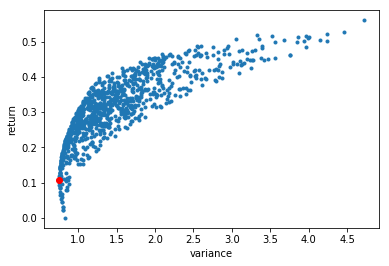

In [99]:
R=[]
V=[]
for i in w:
    R=np.append(R,exp_return(i))
    V=np.append(V,variance(i))
    
plt.plot(V,R,'.')
# plt.plot(0.2,exp_return(s.x),'ro')
plt.plot(min_var, expected_return,'ro')
plt.xlabel('variance')
plt.ylabel('return')
plt.show()  

Here we clearly see that our calculated point is the point with minimum risk but also the effect of the effective frontier. For all points that are not on the border we can find a point that has the same amount of risk but with a higher return. Points not on the border are to be be avoided!!

To create this border we can do a similar algorithm but instead of finding the minimum risk. We can find the maximum return for a given amount of risk and find this optimal weight distribution.

In [100]:
def exp_return2(alpha):
    return -(alpha @ np.transpose(yr_mean.values))

In [101]:
def constraint1(alpha):
    s=sum(alpha)
    return s-1

cons1={'type': 'eq','fun': constraint1}

In [102]:
def constraint2(alpha):
    return variance(alpha)-2

cons2={'type': 'eq','fun': constraint2}
cons=[cons1, cons2]

In [103]:
s=minimize(exp_return2, weight0, constraints=cons, bounds=boundairies(3))

s

     fun: -0.45915684272859114
     jac: array([-0.35608708,  0.00638145, -0.58322362])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.54622112, 0.        , 0.45377888])

In [106]:
v=np.linspace(min_var,min_var+4,100)

In [107]:
vector_r=np.zeros(len(v))
vector_v=np.zeros(len(v))

for i in range(len(vector_v)):
    def constraint2(alpha):
        return variance(alpha)-v[i]

    cons2={'type': 'eq','fun': constraint2}
    cons=[cons1, cons2]

    s=minimize(exp_return2, weight0, constraints=cons, bounds=boundairies(3))
    
    vector_r[i]=-s.fun
    vector_v[i]=variance(s.x)

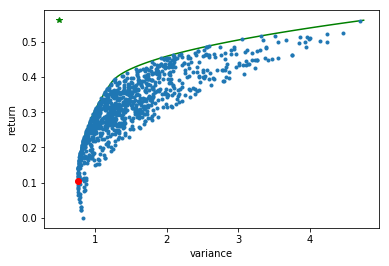

In [110]:
plt.plot(vector_v,vector_r,'g')
plt.plot(V,R,'.')
plt.plot(min_var, expected_return,'ro')
plt.xlim()
plt.xlabel('variance')
plt.ylabel('return')
plt.show()  

Tadaa, this is the effective frontier. One should only take portfolio's that match those on the green line.

In our point of view the most effective point is the point with votalility arround 1.5. At this point an increase in risk does not gives us a decent amount of more return. Before this point an increase in risk gives a high return.

In [60]:
def constraint2(alpha):
    return variance(alpha)-1.4

cons2={'type': 'eq','fun': constraint2}
cons=[cons1, cons2]

P=minimize(exp_return2, weight0, constraints=cons, bounds=boundairies(3))

portfolio=P.x
P_x=variance(portfolio)
P_y=-P.fun

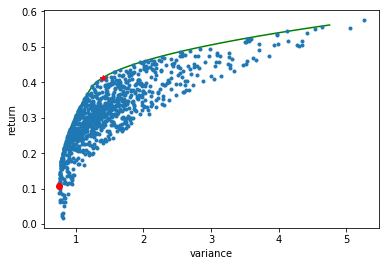

In [61]:
plt.plot(vector_v,vector_r,'g')
plt.plot(V,R,'.')
plt.plot(P_x, P_y,'r*')
plt.plot(min_var, expected_return,'ro')
plt.xlim()
plt.xlabel('variance')
plt.ylabel('return')
plt.show()  

# Find minimum risk for more stocks.

In [62]:
tickers_list = ['JPM','AAPL','TSLA', 'NTDOY','AMD','DUO']
tickers_list=sorted(tickers_list)
tickers_list

['AAPL', 'AMD', 'DUO', 'JPM', 'NTDOY', 'TSLA']

In [63]:
n=len(tickers_list)

[*********************100%***********************]  6 of 6 completed


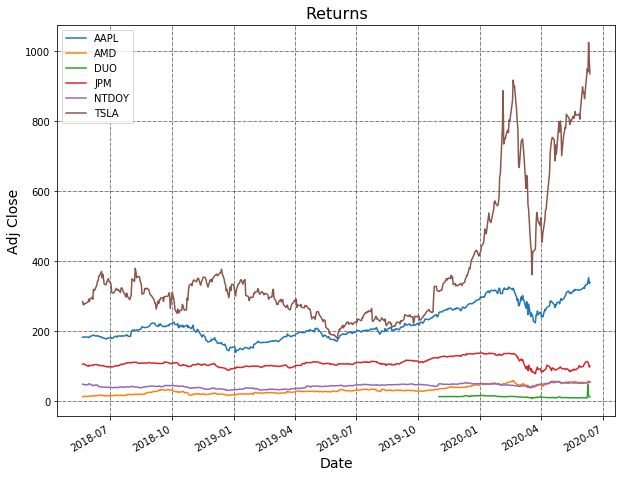

In [64]:
# Get the data for the stock AAPL
data = yf.download(tickers_list,'2018-05-20',today)
(data['Adj Close']).plot(figsize=(10,8),linestyle='-')
plt.title('Returns', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adj Close',fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.legend()
plt.show()

In [65]:
d=yf.download(tickers_list,'2018-01-01',today,interval='1mo')
mdata=d['Adj Close'].dropna()

[*********************100%***********************]  6 of 6 completed


In [66]:
mreturn=mdata.pct_change()
yr_return=mreturn.multiply(365/mdata.index.to_series().diff().dt.days, axis="index")

In [67]:
yr_mean=yr_return.mean()
yr_mean

AAPL     0.469718
AMD      0.578268
DUO      0.162276
JPM     -0.387269
NTDOY    0.286272
TSLA     2.204763
dtype: float64

In [68]:
yr_var=yr_return.var()
yr_var

AAPL      1.335509
AMD       0.924998
DUO       7.754447
JPM       1.743213
NTDOY     1.128232
TSLA     10.507127
dtype: float64

### Covariance Matrix

In [69]:
covar=yr_return.cov()
covar

,AAPL,AMD,DUO,JPM,NTDOY,TSLA
AAPL,1.335509,0.824227,-0.789559,1.336303,0.137759,2.566006
AMD,0.824227,0.924998,-0.440099,0.802775,0.167058,1.701495
DUO,-0.789559,-0.440099,7.754447,-1.037865,1.730590,-5.509862
JPM,1.336303,0.802775,-1.037865,1.743213,-0.248231,2.778971
NTDOY,0.137759,0.167058,1.730590,-0.248231,1.128232,-1.491674
TSLA,2.566006,1.701495,-5.509862,2.778971,-1.491674,10.507127


In [70]:
np_covar=covar.values

In [71]:
def exp_return(alpha):
    return alpha @ np.transpose(yr_mean.values)

In [72]:
def variance(alpha):
    term1=0
    term2=0
    for i in range(len(alpha)):        
        for j in range(len(alpha)):
            if i!=j:
                term2+=alpha[i]*alpha[j]*np_covar[i,j]
            else:
                term1+=(alpha[i]**2)*np_covar[i,i]
    return term1+term2

In [73]:
def constraint(alpha):
    s=sum(alpha)
    return 1-s

con1=[{'type': 'eq','fun': constraint}]

In [74]:
def boundairies(N):
    lijst=[]
    b=(0,1)
    return [b for x in range(N)]

In [75]:
def alpha0(N):
    return np.array([1/N for x in range(N)])

In [76]:
weight0=alpha0(n)
weight0=np.array([0.1, 0.1, 0.5, 0.1, 0.1,
       0.1])

In [77]:
sol=minimize(variance, weight0, constraints=con1,bounds=boundairies(n))
sol

     fun: 0.5224745292822828
     jac: array([1.24830386, 1.04498231, 1.04495807, 1.04492703, 1.04495468,
       1.04479631])
 message: 'Optimization terminated successfully.'
    nfev: 57
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([8.29049507e-17, 2.31967749e-01, 2.93107314e-02, 2.17799165e-01,
       4.82502437e-01, 3.84199166e-02])

In [79]:
expected_return=(sol.x)@(np.transpose(yr_mean.values))
expected_return

0.27738299075249934

In [80]:
min_var= sol.fun
min_var

0.5224745292822828

In [81]:
print('Weights distribution with least amount of risk')

for item_a, item_b in zip(tickers_list, sol.x):
    print(item_a, round(item_b,3)*100)


print('')
print( 'Expected return:' , round(expected_return,3)*100, '%' )
print('Variance:' , round(min_var,3), '%')

Weights distribution with least amount of risk
AAPL 0.0
AMD 23.200000000000003
DUO 2.9000000000000004
JPM 21.8
NTDOY 48.3
TSLA 3.8

Expected return: 27.700000000000003 %
Variance: 0.522 %


## Make plot

We want to see if this is indeed the minimum, therefore we put in some random numbers with the constraint that the weight is equal to 1.

In [191]:
import random

In [192]:
@jit(nopython=True)
def rand_port(size_w):
    array=np.arange(size_w)
    for i in array:
        array[i]=random.randint(0,100)
    array=array/np.sum(array)
    return array

In [193]:
rand_port(len(weight0))

array([0.43298969, 0.08762887, 0.47938144])

In [194]:
type(np.zeros(6))

numpy.ndarray

In [195]:
def scatter_port(N,size_w):
    for i in range(N):
        if i ==0:
            w=rand_port(size_w)
        else:
            x=rand_port(size_w)
            w=np.vstack((w,x))
    return w#[1:,:]

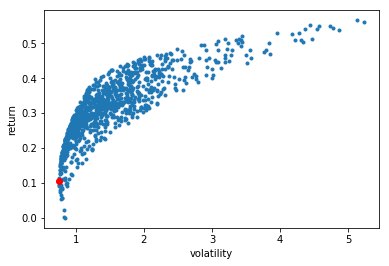

In [196]:
N=1000
portfolios=scatter_port(N,len(weight0))
R=np.zeros(len(portfolios))
V=np.zeros(len(portfolios))
k=0
for i in portfolios:
    R[k]=exp_return(i)
    V[k]=variance(i)
    k+=1
    
plt.plot(V,R,'.')
# plt.plot(0.2,exp_return(s.x),'ro')
plt.plot(min_var, expected_return,'ro')
plt.xlabel('volatility')
plt.ylabel('return')
plt.show()  

Here we clearly see that our calculated point is the point with minimum risk but also the effect of the effective frontier. For all points that are not on the border we can find a point that has the same amount of risk but with a higher return. Points not on the border are to be be avoided!!

To create this border we can do a similar algorithm but instead of finding the minimum risk. We can find the maximum return for a given amount of risk and find this optimal weight distribution.

In [197]:
def exp_return2(alpha):
    return -(alpha @ np.transpose(yr_mean.values))

In [198]:
def constraint1(alpha):
    s=sum(alpha)
    return s-1

cons1={'type': 'eq','fun': constraint1}

In [218]:
def constraint2(alpha):
    return variance(alpha)-1.275

cons2={'type': 'eq','fun': constraint2}
cons=[cons1, cons2]

In [219]:
s=minimize(exp_return2, weight0, constraints=cons, bounds=boundairies(len(weight0)))

s

     fun: -0.3951987585556245
     jac: array([-0.35608708,  0.00638145, -0.58322362])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.82780542, 0.        , 0.17219458])

In [220]:
sum(s.x)

1.0

In [221]:
exp_return(s.x)

0.3951987585556245

In [222]:
v=np.linspace(min_var,min_var+2,100)

In [223]:
vector_r=np.zeros(len(v))
vector_v=np.zeros(len(v))

for i in range(len(vector_v)):
    def constraint2(alpha):
        return variance(alpha)-v[i]

    cons2={'type': 'eq','fun': constraint2}
    cons=[cons1, cons2]

    q=minimize(exp_return2, weight0, constraints=cons, bounds=boundairies(len(weight0)))
    
    vector_r[i]=-q.fun
    vector_v[i]=variance(q.x)

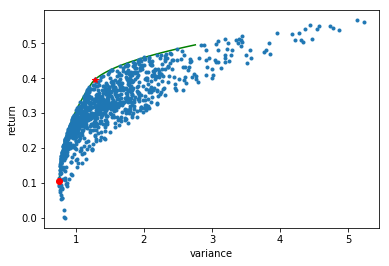

In [224]:
plt.plot(vector_v,vector_r,'g')
plt.plot(V,R,'.')
plt.plot(1.275,-s.fun,'r*')
plt.plot(min_var, expected_return,'ro')
plt.xlim()
plt.xlabel('variance')
plt.ylabel('return')
plt.show()  

In this case our optimal point would be the star point on this graph because after this the tail flattens and it would not be as rewarding to risk more.

In [229]:
print('Weights distribution of this optimal portfolio')

for item_a, item_b in zip(tickers_list, sol.x):
    print(item_a, round((round(item_b,3)*100),3))


print('')
print( 'Expected annual return:' ,'%.1f' %  round(round(float(-s.fun),3)*100,3), '%' )
print('Variance:' , 1.25, '%')

Weights distribution of this optimal portfolio
AAPL 28.8
JPM 69.8
TSLA 1.4

Expected annual return: 39.5 %
Variance: 1.25 %
